In [2]:
import pandas as pd

In [52]:
covid_data = pd.read_csv('data/covid_data.csv')
country_vac = pd.read_csv('data/country_vaccinations.csv')
country_vac = country_vac[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

In [13]:
country_vac.head()

,country,date,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,Afghanistan,2021-02-22,0.0,0.0,0.0,NaN,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
2,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
3,Afghanistan,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
4,Afghanistan,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."


In [14]:
# Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. 
# Тем самым переходим от данных по регионам к данным по странам:
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

In [15]:
# Преобразуем даты в формат datetime с помощью функции pd.to_datetime():
covid_data['date'] = pd.to_datetime(covid_data['date'])

In [16]:
# Создадим признак больных на данный момент (active). 
# Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

In [17]:
# Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. 
# Для этого отсортируем данные по названиям стран, а затем по датам. 
# После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

In [18]:
# В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:
country_vac['date'] = pd.to_datetime(country_vac['date'])

In [19]:
country_vac['date'].max()

Timestamp('2021-09-06 00:00:00')

In [20]:
covid_df = covid_data.merge(country_vac, on=['date', 'country'], how='left')
print('Число строк: ', covid_df.shape[0])
print('Число столбцов: ', covid_df.shape[1])

Число строк:  86785
Число столбцов:  16


In [21]:
covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
covid_df['death_rate']=covid_df['deaths']/covid_df['confirmed']*100

In [27]:
covid_df['recover_rate'] = covid_df['recovered'] / covid_df['confirmed'] * 100
round(covid_df[covid_df['country'] == 'United States']['death_rate'].max(), 2)

7.19

In [30]:
round(covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean(), 2)

67.06

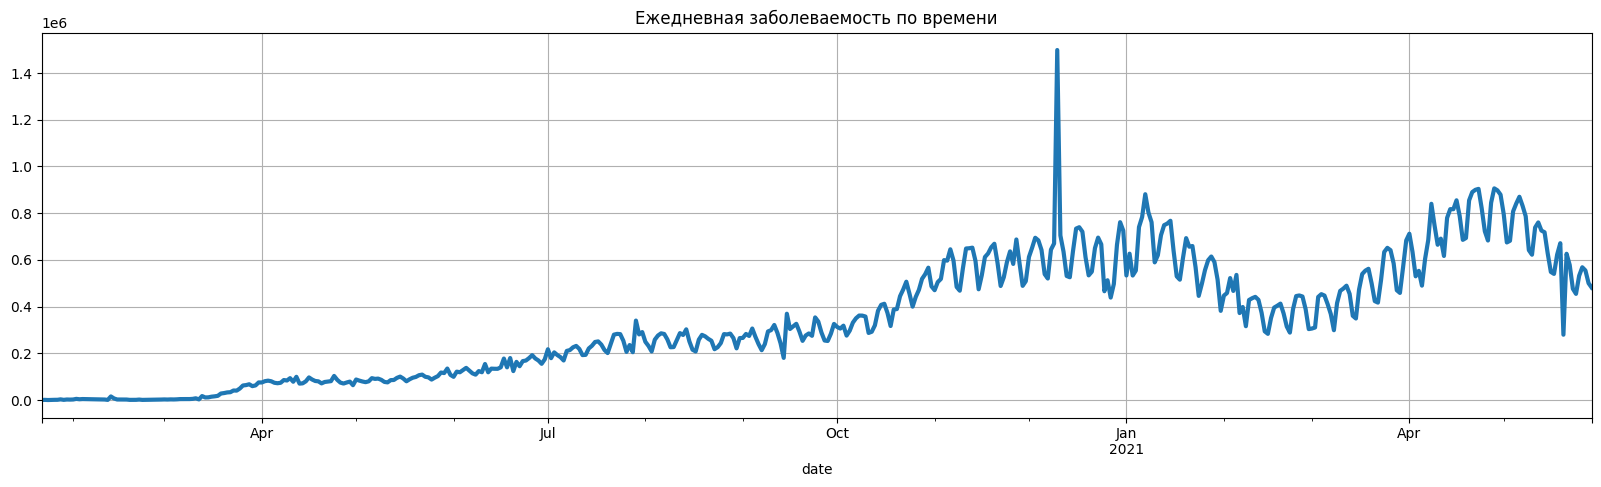

In [38]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(20, 5),
    title='Ежедневная заболеваемость по времени',
    grid = True,
    lw=3
);

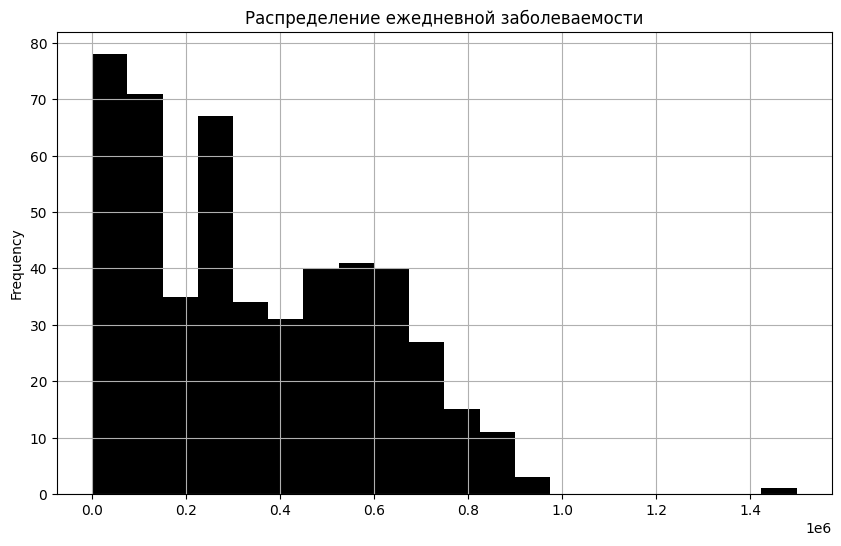

In [40]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=20
);

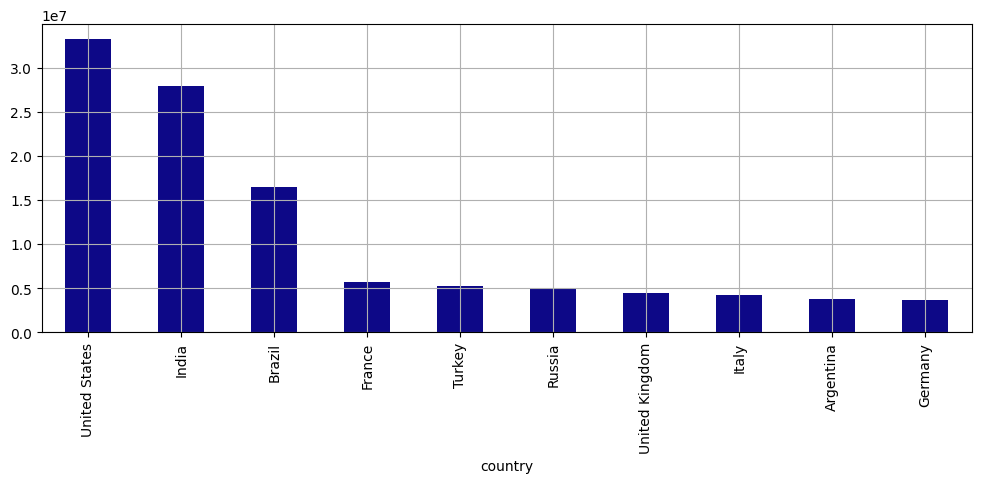

In [41]:
grouped_country = covid_df.groupby('country')['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

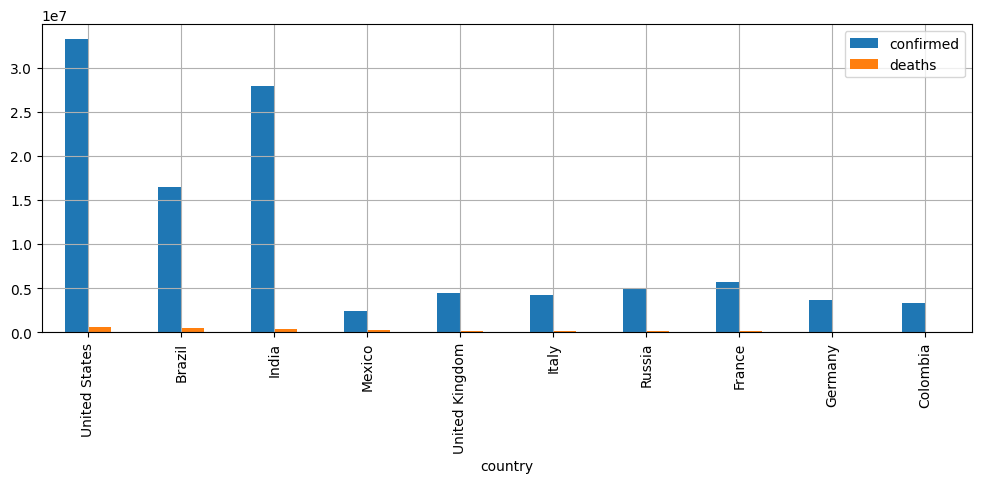

In [46]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['deaths'])
grouped_country.plot(     kind='bar',     grid=True,     figsize=(12, 4), );

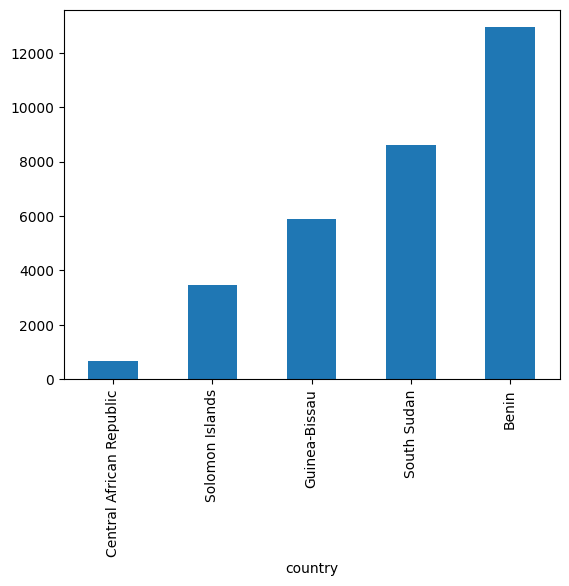

In [47]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86785 entries, 0 to 86784
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 86785 non-null  datetime64[ns]
 1   country                              86785 non-null  object        
 2   confirmed                            86785 non-null  float64       
 3   deaths                               86785 non-null  float64       
 4   recovered                            86785 non-null  float64       
 5   active                               86785 non-null  float64       
 6   daily_confirmed                      86564 non-null  float64       
 7   daily_deaths                         86564 non-null  float64       
 8   daily_recovered                      86564 non-null  float64       
 9   total_vaccinations                   10629 non-null  float64       
 10  people_vac

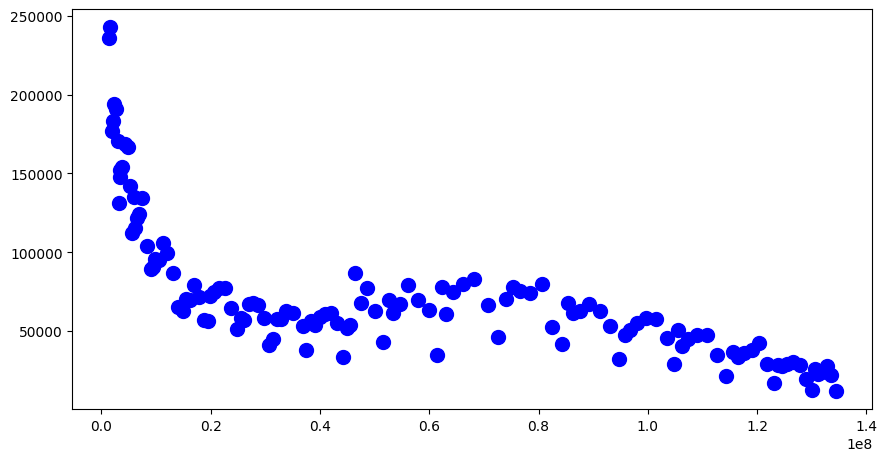

In [56]:
us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
);

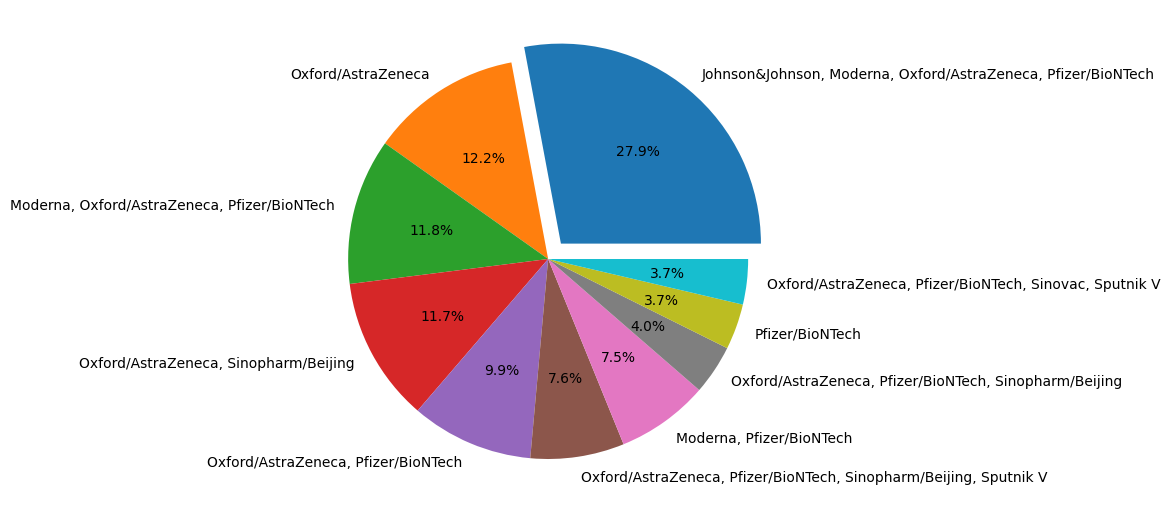

In [57]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

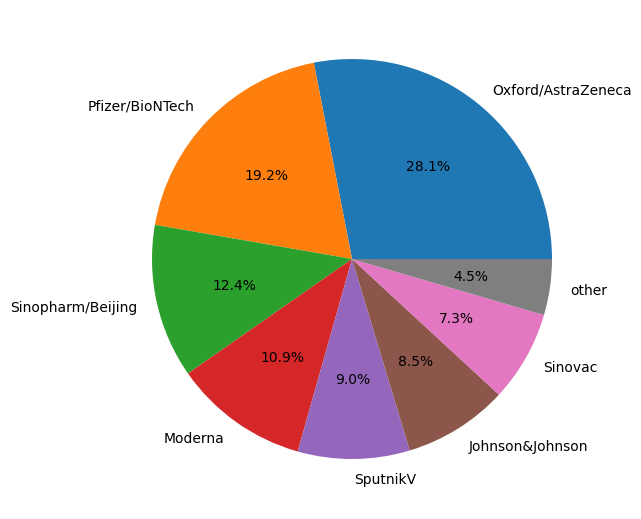

In [59]:
#избавляемся от пропусков в столбце с вакцинами
combination_not_nan = covid_df.dropna(subset=['vaccines'])
#группируем по странам и выбираем последнюю комбинацию вакцин в стране
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last() 
#заменяем пробелы в строках и делим комбинации на отдельные вакцины по запятой
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(',')) 
#создаём пустой словарь, ключами которого будут вакцины, а значениями — количество стран
vaccines_dict = {} 
#создаём цикл по элементам Series combination_last
for vaccines_list in combination_last:
    #создаём цикл по элементам списка с вакцинами
    for vaccine in vaccines_list:
        #проверяем условие, что текущей вакцины ещё нет среди ключей словаря
        if vaccine not in vaccines_dict:#если условие выполняется
            vaccines_dict[vaccine] = 1 #заносим вакцину в словарь со значением 1
        else: #в противном случае
            vaccines_dict[vaccine] += 1 #увеличивает количество
#преобразуем словарь в Series
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
#выделяем ТОП-7 вакцин и добавляем категорию 'other'
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]
#строим круговую диаграмму
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
);